In [356]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, VALID_METRICS_SPARSE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.decomposition import SparsePCA
from sklearn.model_selection import ShuffleSplit

In [130]:
def get_reviews_df():
    reviews_df = pd.read_pickle('./data/reviews_df.pickle')
    return reviews_df

In [244]:
def get_scores(reviews_df):
    random_states, s1s, s2s, s3s = (list() for i in range(4))
    for n in range(100):
        X_train, X_test, y_train, y_test = train_test_split(reviews_df.clean_reviews, reviews_df.ratings, random_state=n, test_size=0.20)
        
        pipe = make_pipeline(TfidfVectorizer(), KNeighborsClassifier())
        pipe.fit(X_train, y_train)
        s1 = pipe.score(X_test, y_test)
        
        pipe = make_pipeline(CountVectorizer(), KNeighborsClassifier())
        pipe.fit(X_train, y_train)
        s2 = pipe.score(X_test, y_test)
        
        pipe = make_pipeline(HashingVectorizer(), KNeighborsClassifier())
        pipe.fit(X_train, y_train)
        s3 = pipe.score(X_test, y_test)
        
        random_states.append(n)
        s1s.append(s1) 
        s2s.append(s2)
        s3s.append(s3)
    return random_states, s1s, s2s, s3s

In [245]:
def metrics_to_df(random_states, s1s, s2s, s3s):
    metrics_df = pd.DataFrame(columns=['random_state', 'TfidfVectorizer', 'CountVectorizer', 'HashingVectorizer'])
    metrics_df.random_state = random_states
    metrics_df.TfidfVectorizer = s1s
    metrics_df.CountVectorizer = s2s
    metrics_df.HashingVectorizer = s3s
    return metrics_df

In [246]:
def main():
    reviews_df = get_reviews_df()
    random_states, s1s, s2s, s3s = get_scores(reviews_df)
    metrics_df = metrics_to_df(random_states, s1s, s2s, s3s)
    return metrics_df

In [247]:
metrics_df = main()

In [248]:
metrics_df.describe()

,random_state,TfidfVectorizer,CountVectorizer,HashingVectorizer
count,100.000000,100.000000,100.000000,100.00000
mean,49.500000,0.567500,0.545500,0.49500
std,29.011492,0.114454,0.101029,0.09962
min,0.000000,0.300000,0.300000,0.25000
25%,24.750000,0.500000,0.450000,0.45000
50%,49.500000,0.575000,0.550000,0.50000
75%,74.250000,0.650000,0.650000,0.55000
max,99.000000,0.800000,0.700000,0.75000


## Explore

In [249]:
pipe.get_params()

{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer()),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(),
 'kneighborsclassifier': KNeighborsClassifier(),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': numpy.float64,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': False,
 'tfidfvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidfvectorizer__tokenizer': None,
 'tfidfvectorizer__use_idf': Tr

In [387]:
n=20
X_train, X_test, y_train, y_test = train_test_split(reviews_df.clean_reviews, reviews_df.ratings, random_state=n, test_size=0.25)
pipe = Pipeline([('vectorizer', TfidfVectorizer()), ('classifier', KNeighborsClassifier())])
pipe.fit(X_train, y_train)
s1 = pipe.score(X_test, y_test)

standard_params = {
    'classifier': [KNeighborsClassifier()],
    'vectorizer': [TfidfVectorizer()]
}
knn_params = {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': (2,3,4,5,6,7,8),
        'classifier__metric': ('cosine', 'euclidean', 'manhattan')
    }
tfidf_params = {
        'vectorizer': [TfidfVectorizer()],
        'vectorizer__max_df': [x/10 for x in range(3,11)],
        'vectorizer__min_df': [x/10 for x in range(0,3)],
        'vectorizer__ngram_range': ((1, 1), (1,2)),
        'vectorizer__norm': ('l2','l1')
    }
count_params = {
    'vectorizer': [CountVectorizer()]
}
hashing_params = {
    'vectorizer': [HashingVectorizer()]
}
grid_parameters = [
    {**knn_params, **tfidf_params}, 
    {**knn_params, **count_params},
    {**knn_params, **hashing_params},
    {**standard_params}
]

cv_shuffle_split = ShuffleSplit(n_splits=1, train_size=0.9, test_size=0.1, random_state=n)
grid_search = GridSearchCV(pipe, grid_parameters, scoring='accuracy', verbose=1, cv=cv_shuffle_split)
grid_search.fit(X_train, y_train)

Fitting 1 folds for each of 2058 candidates, totalling 2058 fits


GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=7, test_size=0.1, train_size=0.9),
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid=[{'classifier': [KNeighborsClassifier(metric='cosine',
                                                              n_neighbors=3)],
                          'classifier__metric': ('cosine', 'euclidean',
                                                 'manhattan'),
                          'classifier__n_neighbors': (2, 3...
                          'classifier__metric': ('cosine', 'euclidean',
                                                 'manhattan'),
                          'classifier__n_neighbors': (2, 3, 4, 5, 6, 7, 8),
                          'vectorizer': [CountVectorizer()]},
                         {'classifier': [KNeighborsClassifier(metric='cosine',
                                                 

In [383]:
# n=15
# X_train, X_test, y_train, y_test = train_test_split(reviews_df.clean_reviews, reviews_df.ratings, random_state=n, test_size=0.25)

In [390]:
print(grid_search.best_score_)
print(grid_search.best_params_)
grid_estimater = grid_search.best_estimator_
print(grid_estimater.score(X_test, y_test))
grid_pred = grid_search.predict(X_test)
print(classification_report(y_test, grid_pred))
# plot_confusion_matrix(grid_estimater, X_test, y_test)

0.875
{'classifier': KNeighborsClassifier(metric='cosine', n_neighbors=3), 'classifier__metric': 'cosine', 'classifier__n_neighbors': 3, 'vectorizer': TfidfVectorizer(max_df=0.5, min_df=0.2), 'vectorizer__max_df': 0.5, 'vectorizer__min_df': 0.2, 'vectorizer__ngram_range': (1, 1), 'vectorizer__norm': 'l2'}
0.6
              precision    recall  f1-score   support

          +1       0.50      0.70      0.58        10
          -1       0.73      0.53      0.62        15

    accuracy                           0.60        25
   macro avg       0.61      0.62      0.60        25
weighted avg       0.64      0.60      0.60        25



0.6
              precision    recall  f1-score   support

          +1       0.50      0.60      0.55        10
          -1       0.69      0.60      0.64        15

    accuracy                           0.60        25
   macro avg       0.60      0.60      0.59        25
weighted avg       0.62      0.60      0.60        25



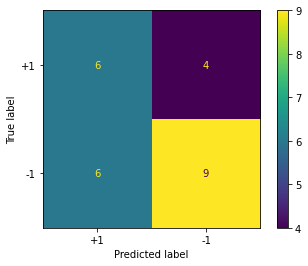

In [391]:
print(pipe.score(X_test, y_test))
pred = pipe.predict(X_test)
print(classification_report(y_test, pred))
plot_confusion_matrix(pipe, X_test, y_test)